In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler # Class Imbalance

# Numerical features selection
from sklearn.decomposition import PCA

# Categorical Features Selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

# Classification Models
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Model Optimization
from sklearn.model_selection import GridSearchCV

#Metrics
from sklearn import metrics



# Other General Imports
import gc
%matplotlib inline
import time
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

# Data Loading and Reducing the Size

Since the data is big in size, we will use function to reduce its memory for fast processing and consuming less storage.

In [2]:
start = time.time()
# Helper function
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
# loading train_transaction data
tt = pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv')
print(tt.shape)
tt = reduce_mem_usage(tt)

# loading train_transaction data
ti = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv')
print(ti.shape)
ti = reduce_mem_usage(ti)

train = pd.merge(tt, ti, how = 'left')
print('Train shape',train.shape)

train.head()

del tt, ti

(590540, 394)
Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 487.16 MB
Decreased by 72.6%
(144233, 41)
Memory usage of dataframe is 45.12 MB
Memory usage after optimization is: 10.00 MB
Decreased by 77.8%
Train shape (590540, 434)


In [4]:
# loading test_transaction data
ts = pd.read_csv('../input/ieee-fraud-detection/test_transaction.csv')
print(ts.shape)
ts = reduce_mem_usage(ts)

tsi = pd.read_csv('../input/ieee-fraud-detection/test_identity.csv')
print(tsi.shape)
tsi = reduce_mem_usage(tsi)

test = pd.merge(ts, tsi, how = 'left')
print('Test shape',test.shape)
test.head()

del ts, tsi

(506691, 393)
Memory usage of dataframe is 1519.24 MB
Memory usage after optimization is: 425.24 MB
Decreased by 72.0%
(141907, 41)
Memory usage of dataframe is 44.39 MB
Memory usage after optimization is: 9.84 MB
Decreased by 77.8%
Test shape (506691, 433)


# Data Preparation

In [5]:
def summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values

    return summary

In [6]:
summary(train)

Dataset Shape: (590540, 434)


,Name,dtypes,Missing,Uniques
0,TransactionID,int32,0,590540
1,isFraud,int8,0,2
2,TransactionDT,int32,0,573349
3,TransactionAmt,float16,0,8195
4,ProductCD,category,0,5
...,...,...,...,...
429,id_36,category,449555,2
430,id_37,category,449555,2
431,id_38,category,449555,2
432,DeviceType,category,449730,2


In [7]:
summary(test)

Dataset Shape: (506691, 433)


,Name,dtypes,Missing,Uniques
0,TransactionID,int32,0,506691
1,TransactionDT,int32,0,494686
2,TransactionAmt,float16,0,7343
3,ProductCD,category,0,5
4,card1,int16,0,13244
...,...,...,...,...
428,id-36,category,369714,2
429,id-37,category,369714,2
430,id-38,category,369714,2
431,DeviceType,category,369760,2


## Feature Engineering 1

### Handling and Genearating Features

In [8]:
def Devices(df):
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]
    df['device_version'] = df['DeviceInfo'].str.split('/', expand=True)[1]
    df = df.drop(['DeviceInfo'], axis = 1)
    
    df['OS_id_30'] = df['id_30'].str.split(' ', expand=True)[0]
    df['version_id_30'] = df['id_30'].str.split(' ', expand=True)[1]
    df = df.drop(['id_30'], axis = 1)
    
    df['browser_id_31'] = df['id_31'].str.split(' ', expand=True)[0]
    df['version_id_31'] = df['id_31'].str.split(' ', expand=True)[1]
    df = df.drop(['id_31'], axis = 1)

    df['screen_width'] = df['id_33'].str.split('x', expand=True)[0]
    df['screen_height'] = df['id_33'].str.split('x', expand=True)[1]
    df = df.drop(['id_33'], axis = 1)

    df['id_34'] = df['id_34'].str.split(':', expand=True)[1]
    df['id_23'] = df['id_23'].str.split(':', expand=True)[1]
    df = df.drop(['id_34', 'id_23'], axis = 1)


    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    df['had_id'] = 1
    gc.collect()
    
    return df

train = Devices(train)

In [9]:
def DevicesT(df):
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]
    df['device_version'] = df['DeviceInfo'].str.split('/', expand=True)[1]
    df = df.drop(['DeviceInfo'], axis = 1)
    
    df['OS_id_30'] = df['id-30'].str.split(' ', expand=True)[0]
    df['version_id_30'] = df['id-30'].str.split(' ', expand=True)[1]
    df = df.drop(['id-30'], axis = 1)
    
    df['browser_id_31'] = df['id-31'].str.split(' ', expand=True)[0]
    df['version_id_31'] = df['id-31'].str.split(' ', expand=True)[1]
    df = df.drop(['id-31'], axis = 1)

    df['screen_width'] = df['id-33'].str.split('x', expand=True)[0]
    df['screen_height'] = df['id-33'].str.split('x', expand=True)[1]
    df = df.drop(['id-33'], axis = 1)

    df['id-34'] = df['id-34'].str.split(':', expand=True)[1]
    df['id-23'] = df['id-23'].str.split(':', expand=True)[1]
    df = df.drop(['id-34', 'id-23'], axis = 1)


    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    df['had_id'] = 1
    gc.collect()
    
    return df


test = DevicesT(test)

## Dealing with Missing Data

In [10]:
y = train['isFraud']
TrainTransactionID = train['TransactionID']
TrainTransactionDT = train['TransactionDT']

In [11]:
TestTransactionID = test['TransactionID']
TestTransactionDT = test['TransactionDT']

In [12]:
train = train.drop(['TransactionID', 'TransactionDT' , 'isFraud'], axis = 1)

In [13]:
test = test.drop(['TransactionID', 'TransactionDT'], axis = 1)

In [14]:
# Dropping columns with more than 80% missing values 
print("Train shape before dropping features more than 30% missing values: ", train.shape)
mv = train.isnull().sum()/len(train)
train = train.drop(columns=mv[mv>0.7].index)

print("Train shape after dropping features more than 30% missing values: ", train.shape)

Train shape before dropping features more than 30% missing values:  (590540, 434)
Train shape after dropping features more than 30% missing values:  (590540, 224)


In [15]:
print("Test shape before dropping features more than 30% missing values: ", test.shape)
mv = test.isnull().sum()/len(test)
test = test.drop(columns=mv[mv>0.7].index)

print("Test shape after dropping features more than 30% missing values: ", test.shape)

Test shape before dropping features more than 30% missing values:  (506691, 434)
Test shape after dropping features more than 30% missing values:  (506691, 224)


In [16]:
train.dropna(how= 'all', axis = 0)

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,V313,V314,V315,V316,V317,V318,V319,V320,V321,had_id
0,68.500000,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,...,0.0000,0.0000,0.0000,0.0,117.0,0.0,0.000000,0.000000,0.000000,1
1,29.000000,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,...,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1
2,59.000000,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,...,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1
3,50.000000,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,...,0.0000,0.0000,0.0000,50.0,1404.0,790.0,0.000000,0.000000,0.000000,1
4,50.000000,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,...,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,49.000000,W,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,...,47.9375,47.9375,47.9375,0.0,0.0,0.0,0.000000,0.000000,0.000000,1
590536,39.500000,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,...,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1
590537,30.953125,W,12037,595.0,150.0,mastercard,224.0,debit,231.0,87.0,...,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1
590538,117.000000,W,7826,481.0,150.0,mastercard,224.0,debit,387.0,87.0,...,317.5000,669.5000,317.5000,0.0,2234.0,0.0,0.000000,0.000000,0.000000,1


In [17]:
test.dropna(how= 'all', axis = 0)

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,V313,V314,V315,V316,V317,V318,V319,V320,V321,had_id
0,31.953125,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,...,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1
1,49.000000,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,...,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1
2,171.000000,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,...,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,263.0,0.0,1
3,285.000000,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,...,282.50000,282.50000,282.50000,0.0,0.0,0.0,0.0,0.0,0.0,1
4,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,...,67.93750,183.87500,67.93750,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,94.687500,C,13832,375.0,185.0,mastercard,224.0,debit,284.0,60.0,...,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1
506687,12.171875,C,3154,408.0,185.0,mastercard,224.0,debit,NaN,NaN,...,31.71875,31.71875,31.71875,0.0,0.0,0.0,0.0,0.0,0.0,1
506688,49.000000,W,16661,490.0,150.0,visa,226.0,debit,327.0,87.0,...,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1
506689,202.000000,W,16621,516.0,150.0,mastercard,224.0,debit,177.0,87.0,...,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1


In [18]:
# Filtering numerical data
num_df = train.select_dtypes(include=np.number)
print(num_df.shape)

# Filtering categorical data
cat_df = train.select_dtypes(exclude=np.number)
print(cat_df.shape)

(590540, 211)
(590540, 13)


In [19]:
# Filtering numerical data
num_df_test = test.select_dtypes(include=np.number)
print(num_df.shape)

# Filtering categorical data
cat_df_test = test.select_dtypes(exclude=np.number)
print(cat_df.shape)

(590540, 211)
(590540, 13)


In [20]:
del train
del test
gc.collect()

69

In [21]:
# Filling missing values by median for numerical columns 
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
num_df = pd.DataFrame(imp_median.fit_transform(num_df), columns=num_df.columns)
print(num_df.shape)

# Filling missing values by most frequent value for categorical columns
for i in cat_df:
    cat_df[i] = cat_df[i].fillna(np.NaN)
    
cat_df.isnull().sum()
num_df.isnull().sum()

(590540, 211)


TransactionAmt    0
card1             0
card2             0
card3             0
card5             0
                 ..
V318              0
V319              0
V320              0
V321              0
had_id            0
Length: 211, dtype: int64

In [22]:
# Filling missing values by median for numerical columns 
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
num_df_test = pd.DataFrame(imp_median.fit_transform(num_df_test), columns=num_df_test.columns)
print(num_df_test.shape)

# Filling missing values by most frequent value for categorical columns
for i in cat_df_test:
    cat_df_test[i] = cat_df_test[i].fillna(np.NaN)
    
cat_df_test.isnull().sum()
num_df_test.isnull().sum()

(506691, 211)


TransactionAmt    0
card1             0
card2             0
card3             0
card5             0
                 ..
V318              0
V319              0
V320              0
V321              0
had_id            0
Length: 211, dtype: int64

## Numerical Features

In [23]:
scaled_num = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(num_df), columns = num_df.columns)
scaled_num.head()

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,...,V313,V314,V315,V316,V317,V318,V319,V320,V321,had_id
0,0.002137,0.743044,0.522,0.381679,0.306569,0.488636,0.836957,0.001847,0.000213,0.000176,...,0.0,0.0,0.0,0.000000,0.000873,0.000000,0.0,0.0,0.0,0.0
1,0.000900,0.100885,0.608,0.381679,0.014599,0.511364,0.836957,0.000778,0.000213,0.000176,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.001840,0.210566,0.780,0.381679,0.481752,0.522727,0.836957,0.027897,0.000213,0.000176,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.001558,0.984824,0.934,0.381679,0.124088,0.854545,0.836957,0.000778,0.000427,0.000878,...,0.0,0.0,0.0,0.000533,0.010476,0.008022,0.0,0.0,0.0,0.0
4,0.001558,0.201023,0.828,0.381679,0.014599,0.727273,0.836957,0.000778,0.000213,0.000176,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [24]:
scaled_num_test = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(num_df_test), columns = num_df_test.columns)
scaled_num_test.head()

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,...,V313,V314,V315,V316,V317,V318,V319,V320,V321,had_id
0,0.003109,0.540814,0.022,0.378788,0.919708,0.159091,0.836957,0.000124,0.002034,0.001832,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.004769,0.188032,0.022,0.378788,0.919708,0.452273,0.836957,0.000495,0.001017,0.000611,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.016645,0.199759,0.948,0.378788,0.919708,0.845455,0.836957,0.326238,0.000678,0.000611,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000435,0.0,0.0
3,0.027744,0.574155,0.520,0.378788,0.481752,0.238636,0.836957,0.002104,0.001695,0.000611,...,0.059750,0.037467,0.059750,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.006612,0.978213,0.704,0.378788,0.124088,0.372727,0.836957,0.000743,0.002034,0.001832,...,0.014369,0.024387,0.014369,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


### PCA for Numerical Features

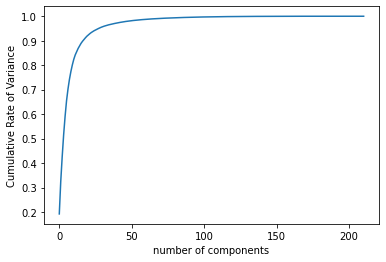

In [25]:
#optimuadd_suffixm number of components
pca = PCA().fit(scaled_num)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("Cumulative Rate of Variance")

#final
pca = PCA(n_components = 0.99)

pca_fit = pca.fit_transform(scaled_num)
num_pca = pd.DataFrame(data = pca_fit)
pca.explained_variance_ratio_.sum()
del num_df, scaled_num

In [26]:
num_pca.shape

(590540, 68)

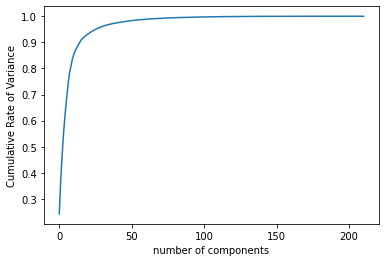

In [27]:
#optimuadd_suffixm number of components
pca_test = PCA().fit(scaled_num_test)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("Cumulative Rate of Variance")

#final
pca_test = PCA(n_components = 68)

pca_fit_test = pca_test.fit_transform(scaled_num_test)
num_pca_test = pd.DataFrame(data = pca_fit_test)
pca_test.explained_variance_ratio_.sum()
del num_df_test, scaled_num_test

In [28]:
num_pca_test.shape

(506691, 68)

## Categorical Features

Due to we have too many values in some categories, we try to map them into new categories.

In [29]:
for x in cat_df.columns:
    #printing unique values
    print(x ,':', len(cat_df[x].unique()))

ProductCD : 5
card4 : 5
card6 : 5
P_emaildomain : 60
M1 : 3
M2 : 3
M3 : 3
M4 : 4
M5 : 3
M6 : 3
M7 : 3
M8 : 3
M9 : 3


In [30]:
cat_df = pd.get_dummies(cat_df)
cat_df.head()

,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,...,M5_F,M5_T,M6_F,M6_T,M7_F,M7_T,M8_F,M8_T,M9_F,M9_T
0,0,0,0,0,1,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,1,0,...,1,0,1,0,1,0,1,0,1,0
3,0,0,0,0,1,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
cat_df_test = pd.get_dummies(cat_df_test)
cat_df_test.head()

,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,...,M5_F,M5_T,M6_F,M6_T,M7_F,M7_T,M8_F,M8_T,M9_F,M9_T
0,0,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,1,0,1,0,1
1,0,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,1,0,...,1,0,1,0,1,0,1,0,1,0
3,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,1,0,0,1,0,1


# Tree-based Categorical Feature Selection

In [33]:
clf = ExtraTreesClassifier(n_estimators=200, criterion = 'entropy')
clf = clf.fit(cat_df, y)

model = SelectFromModel(clf, prefit=True)
feature_idx = model.get_support()
feature_name = cat_df.columns[feature_idx]

cat_new = pd.DataFrame(model.transform(cat_df), columns = feature_name)
cat_new.head()

,ProductCD_C,ProductCD_W,card4_discover,card4_mastercard,card4_visa,card6_credit,card6_debit,P_emaildomain_anonymous.com,P_emaildomain_aol.com,P_emaildomain_comcast.net,...,M4_M0,M4_M1,M4_M2,M5_F,M5_T,M6_F,M6_T,M7_F,M8_F,M9_T
0,0,1,1,0,0,1,0,0,0,0,...,0,0,1,1,0,0,1,0,0,0
1,0,1,0,1,0,1,0,0,0,0,...,1,0,0,0,1,0,1,0,0,0
2,0,1,0,0,1,0,1,0,0,0,...,1,0,0,1,0,1,0,1,1,0
3,0,1,0,1,0,0,1,0,0,0,...,1,0,0,0,1,1,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
cat_new_test = pd.DataFrame(cat_df_test, columns = feature_name)
cat_new_test.head()

,ProductCD_C,ProductCD_W,card4_discover,card4_mastercard,card4_visa,card6_credit,card6_debit,P_emaildomain_anonymous.com,P_emaildomain_aol.com,P_emaildomain_comcast.net,...,M4_M0,M4_M1,M4_M2,M5_F,M5_T,M6_F,M6_T,M7_F,M8_F,M9_T
0,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,1,0,0,1,0,1,0,1,0,...,1,0,0,0,0,1,0,0,0,0
2,0,1,0,0,1,0,1,0,0,0,...,1,0,0,1,0,1,0,1,1,0
3,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,1


### Concatenating Numerical and Categorical Features 

In [35]:
# Concatinating numerical and categorical data
train = pd.concat([y, num_pca, cat_df], axis=1)
train = pd.DataFrame(train)

# Verifying missing values
print(f'Total missing values: {train.isnull().sum().sum()}')
print(train.shape)
train.head()

Total missing values: 0
(590540, 160)


,isFraud,0,1,2,3,4,5,6,7,8,...,M5_F,M5_T,M6_F,M6_T,M7_F,M7_T,M8_F,M8_T,M9_F,M9_T
0,0,-0.354139,-0.124919,0.163122,0.428223,0.053224,-0.199790,0.073889,0.039031,-0.042300,...,1,0,0,1,0,0,0,0,0,0
1,0,-0.357407,0.371495,0.131853,0.134022,0.661790,-0.024058,0.102026,-0.142747,-0.375713,...,0,1,0,1,0,0,0,0,0,0
2,0,-0.100310,-0.127605,-0.200999,0.115881,0.423814,-0.213138,0.115139,-0.191577,0.219137,...,1,0,1,0,1,0,1,0,1,0
3,0,-0.221747,0.044926,-0.129293,0.853642,0.002394,-0.242547,0.422311,-0.013417,-0.035972,...,0,1,1,0,0,0,0,0,0,0
4,0,-0.393445,-0.016916,-0.086041,0.402878,0.668992,-0.196924,0.342893,-0.035454,-0.025343,...,0,0,0,0,0,0,0,0,0,0


In [36]:
del  num_pca, cat_df, cat_new, y
gc.collect()

6296

In [37]:
# Concatinating numerical and categorical data
test = pd.concat([num_pca_test, cat_df_test], axis=1)
test = pd.DataFrame(test)

# Verifying missing values
print(f'Total missing values: {test.isnull().sum().sum()}')
print(test.shape)
test.head()

Total missing values: 0
(506691, 159)


,0,1,2,3,4,5,6,7,8,9,...,M5_F,M5_T,M6_F,M6_T,M7_F,M7_T,M8_F,M8_T,M9_F,M9_T
0,0.719658,-0.061697,0.393948,-0.287041,-0.157048,0.071296,-0.283290,-0.291346,-0.115504,-0.142350,...,0,0,1,0,0,1,0,1,0,1
1,0.580283,0.021987,0.326819,-0.530887,0.040686,-0.254358,0.397144,0.054992,0.182706,0.016709,...,0,0,1,0,0,0,0,0,0,0
2,-0.046336,0.075647,-0.541449,-0.131516,0.146039,-0.241177,-0.093541,0.413782,0.066835,-0.051349,...,1,0,1,0,1,0,1,0,1,0
3,0.131400,0.449289,0.106730,0.329865,0.201233,0.153778,0.180689,-0.163512,0.094990,0.110765,...,0,0,0,1,0,0,0,0,0,0
4,-0.255962,0.374835,0.153082,0.856126,0.112007,0.194864,-0.025468,-0.048681,0.012547,-0.002419,...,0,0,1,0,1,0,0,1,0,1


In [38]:
del  cat_df_test, num_pca_test, cat_new_test
gc.collect()

46

In [39]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 362.69 MB
Memory usage after optimization is: 184.16 MB
Decreased by 49.2%


In [40]:
train.head()

,isFraud,0,1,2,3,4,5,6,7,8,...,M5_F,M5_T,M6_F,M6_T,M7_F,M7_T,M8_F,M8_T,M9_F,M9_T
0,0,-0.354248,-0.124939,0.163086,0.428223,0.053223,-0.199829,0.073914,0.039032,-0.042297,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,-0.357422,0.371582,0.131836,0.134033,0.661621,-0.024063,0.102051,-0.142700,-0.375732,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,-0.100281,-0.127563,-0.201050,0.115906,0.423828,-0.213135,0.115112,-0.191528,0.219116,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0,-0.221802,0.044922,-0.129272,0.853516,0.002394,-0.242554,0.422363,-0.013420,-0.035980,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,-0.393555,-0.016922,-0.086060,0.402832,0.668945,-0.196899,0.342773,-0.035461,-0.025345,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
test = reduce_mem_usage(test)

Memory usage of dataframe is 306.84 MB
Memory usage after optimization is: 153.66 MB
Decreased by 49.9%


In [42]:
test.shape

(506691, 159)

In [43]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,M5_F,M5_T,M6_F,M6_T,M7_F,M7_T,M8_F,M8_T,M9_F,M9_T
0,0.719727,-0.061707,0.394043,-0.287109,-0.157104,0.071289,-0.283203,-0.291260,-0.115479,-0.142334,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.580078,0.021988,0.326904,-0.530762,0.040680,-0.254395,0.397217,0.054993,0.182739,0.016708,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.046326,0.075623,-0.541504,-0.131470,0.145996,-0.241211,-0.093567,0.413818,0.066833,-0.051361,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.131348,0.449219,0.106750,0.329834,0.201294,0.153809,0.180664,-0.163452,0.094971,0.110779,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.255859,0.374756,0.153076,0.855957,0.112000,0.194824,-0.025467,-0.048676,0.012550,-0.002419,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [44]:
gc.collect()

23

In [45]:
y = train['isFraud']
X = train.drop(['isFraud'], axis = 1)
X_array=np.array(X)

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

print(X_resampled.shape, y_resampled.shape)

pd.value_counts(y_resampled)

(41326, 159) (41326,)


0    20663
1    20663
Name: isFraud, dtype: int64

In [46]:
X_df = pd.DataFrame(X_resampled, columns = X.columns)
y_df = pd.DataFrame(y_resampled)
df = pd.concat([X_df, y_df], axis= 1)
df.shape 
df.head()

,0,1,2,3,4,5,6,7,8,9,...,M5_T,M6_F,M6_T,M7_F,M7_T,M8_F,M8_T,M9_F,M9_T,isFraud
0,-0.128540,-0.369873,-0.386719,-0.129761,0.254395,0.418701,0.467285,0.145996,0.024689,0.015038,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0
1,0.124817,0.231201,0.097534,-0.319824,-0.157471,-0.163330,0.333984,-0.028931,-0.166016,0.314453,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.277344,-0.174683,-0.079041,0.053375,-0.187134,-0.344971,-0.057343,0.182739,-0.051392,0.103333,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,-0.242310,-0.263184,-0.166260,0.023499,-0.255615,-0.146118,0.306885,-0.002563,0.019394,-0.047913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,-0.216187,-0.350830,0.412109,-0.193604,-0.290771,-0.201904,-0.217407,0.033691,0.040771,-0.022354,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [50]:
X = df.drop(["isFraud"], axis = 1)
y = df["isFraud"]

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [52]:
gc.collect()

796

In [53]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler 
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope

In [59]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

space = {
    "bootstrap": hp.choice("bootstrap", [False]),
    "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000]),
    "max_depth": hp.choice("max_depth", [10, 20, 30, 40, 50, 100, 200, 250, 300, 350, 400]),
    "criterion": hp.choice("criterion", ["entropy"]),
    "max_features": hp.choice("max_features", ['sqrt', 'auto']),
    "min_samples_leaf": hp.choice ("min_samples_leaf", [1, 3, 5, 7, 9]),
    "min_samples_split": hp.choice("min_samples_split", [2, 5, 8, 10, 12, 15, 20])
    
}

def hyperparameter_tuning(params):
    rf = RandomForestClassifier(**params,n_jobs=-1, verbose = 0)
    rf.fit(X_train, y_train)
    y_scores = rf.predict_proba(X_test)
    roc= metrics.roc_auc_score(y_test, y_scores[:,1])
    return {"loss": -roc, "status": STATUS_OK}


trials = Trials()

best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=5, 
    trials=trials
)

print("Best: {}".format(best))

100%|██████████| 5/5 [07:21<00:00, 88.33s/trial, best loss: -0.9025497093204311] 
Best: {'bootstrap': 0, 'criterion': 0, 'max_depth': 9, 'max_features': 0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 12}


0.9023719443456645


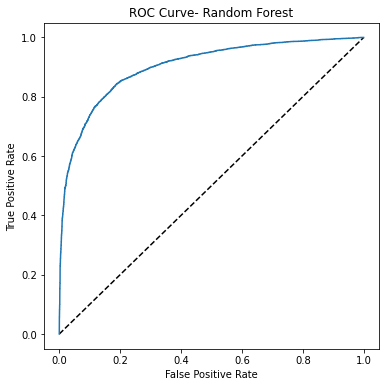

In [60]:
rf = RandomForestClassifier(bootstrap = False,
                            criterion = "entropy",
                            max_depth= 350,
                            n_estimators= 1600,
                            min_samples_split = 12,
                            min_samples_leaf = 3,
                            max_features= 'sqrt')


rf.fit(X_train, y_train)
y_scores = rf.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
RFScore = metrics.auc(fpr, tpr)
print(RFScore)


# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Random Forest')
plt.show()

In [61]:
y_scores = rf.predict_proba(test)

In [62]:
def column(matrix, i):
    return [row[i] for row in matrix]

sub =column(y_scores, 1)

In [63]:
result = pd.DataFrame(sub, columns = ['isFraud'])
transactionID = pd.DataFrame(TestTransactionID)

In [64]:
sub = pd.concat([transactionID, result], axis =1)

In [65]:
sub.head()

,TransactionID,isFraud
0,3663549,0.376024
1,3663550,0.311576
2,3663551,0.408444
3,3663552,0.177187
4,3663553,0.269803


In [66]:
sub.to_csv('sub.csv', index=False)